In [23]:
from dotenv import load_dotenv
load_dotenv()
import openai, os
openai.api_type = "azure"
openai.api_version = "2022-12-01"
os.environ["OPENAI_API_BASE"] = "https://aoai.openai.azure.com/"
openai.api_base = os.environ["OPENAI_API_BASE"]
openai.api_key = os.environ["OPENAI_API_KEY"]

In [17]:
from langchain.docstore.document import Document
from langchain.schema import BaseRetriever, Document
from typing import List
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential

class CognitiveSearchRetriever(BaseRetriever):
    def __init__(self, endpoint: str, index_name: str, searchkey: str, top: int = 3):
        self.endpoint = endpoint
        self.index_name = index_name
        self.searchkey = searchkey
        self.top = top
        self.client = SearchClient(endpoint=endpoint, index_name=index_name, credential=AzureKeyCredential(searchkey))

    def get_relevant_documents(self, query: str) -> List[Document]:
        docs = []
        for i in self.client.search(query, top=self.top):
            docs.append(Document(page_content=i['content'], metadata={"sourcefile": i['sourcefile']}))
        return docs

    async def aget_relevant_documents(self, query: str) -> List[Document]:
        pass

In [18]:
cog_search = CognitiveSearchRetriever(endpoint="https://gptkb-73g2mkes5kahm.search.windows.net/", index_name="amldocs", searchkey=os.environ["COG_SEARCH_KEY"])


In [19]:
cog_search.get_relevant_documents("pipelines")

[Document(page_content='   > You can publish multiple pipelines to a single endpoint. Each pipeline in a given endpoint is given a version number, which you can specify when you call the pipeline endpoint.\n\n1. Select **Publish**.\n\n## Retrain your model\n\nNow that you have a published training pipeline, you can use it to retrain your model on new data. You can submit jobs from a pipeline endpoint from the studio workspace or programmatically.\n\n### Submit jobs by using the studio portal\n\nUse the following steps to submit a parameterized pipeline endpoint job from the studio portal:\n\n1. Go to the **Endpoints** page in your studio workspace.\n1. Select the **Pipeline endpoints** tab. Then, select your pipeline endpoint.\n1. Select the **Published pipelines** tab. Then, select the pipeline version that you want to run.\n1. Select **Submit**.\n1. In the setup dialog box, you can specify the parameters values for the job. For this example, update the data path to train your model u

In [25]:
from langchain.chains import RetrievalQA
from langchain.chat_models import AzureChatOpenAI

llm = AzureChatOpenAI(
    deployment_name="gpt-35-turbo",
    temperature=0,
    openai_api_version="2023-03-15-preview",
)

qa = RetrievalQA.from_chain_type(llm=llm, 
                                    chain_type="stuff",
                                    retriever=cog_search)

In [26]:
qa("What is a pipeline?")

{'query': 'What is a pipeline?',
 'result': 'In the context of Azure Machine Learning, a pipeline is a collection of steps used in machine learning workflows for orchestrating, managing, and automating machine learning projects. A machine learning pipeline in Azure Machine Learning can contain steps from data preparation, to feature extraction, to hyperparameter tuning, to model evaluation. Azure Machine Learning pipelines are particularly powerful in creating reproducible and reusable machine learning workflows with consistent and reliable outcomes.'}

In [32]:
try:
    print("try")
    result = 1/0
except Exception as e:
    print("except")
    result = e
    raise(e)
finally:
    print("finally")
    print(result)

try
except
finally
division by zero


ZeroDivisionError: division by zero

In [34]:
str(result)

'division by zero'

In [35]:
counter = [1]
counter.append(0)
counter

[1, 0]

In [36]:
counter.pop()
counter

[1]

In [32]:

from langchain import PromptTemplate

labeling_template = """
# Comparative labeling task for chatbot messages

Description: You will be reviewing and comparing two different messages generated by a chatbot in response to the same question, and selecting the better message based on provided criteria. This is an offline task, meaning you will not be responding in real-time to users.

Tasks:

1. Review the two chat messages (response A and response B) generated by the chatbot in response to the same question.
2. Evaluate each message based on the provided criteria:
    - Is the message relevant to the user's question?
    - Is the message helpful or informative?
    - Does the message address the user's question or concern?
    - Is the message grammatically correct and free of errors?
3. Select label A if you think A is the better reply, select label B if you think B is the better reply. 
Choose "No preference" if you think both messages are equally good or equally bad.

# Question

{question}

# Response A

{response_a}

# Response B

{response_b}

# Label

Preferred response: 
"""

labeling_prompt_template = PromptTemplate(template=labeling_template, input_variables=["question", "response_a", "response_b"])

Counts: Counter({'A': 2, 'B': 1})


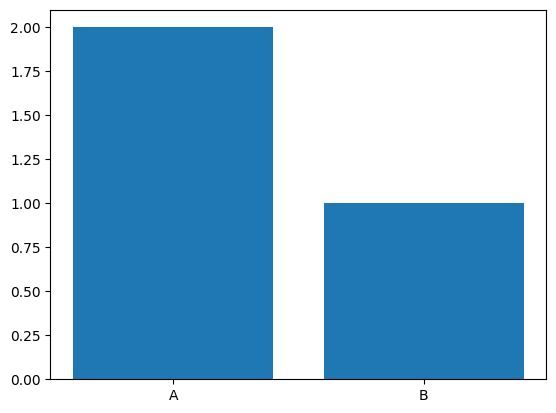

In [39]:
# load scores from data/amldocs/compare_labeling/scores.json
import json
with open("./data/amldocs/compare_labeling/scores.json", "r") as f:
    scores = json.load(f)

from collections import Counter
counts = Counter([x["result"] for x in scores])
print("Counts:", counts)

# create a bar chart of the counts
import matplotlib.pyplot as plt
plt.bar(counts.keys(), counts.values())
#save plot
plt.savefig("test.png", bbox_inches='tight')
